## Introduction

ACME is one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

At ACME we thrive for making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me


Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

## Importing Data

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
df = pd.read_csv("ACME-HappinessSurvey2020.csv")

## Data Analysis

In [140]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [141]:
df.describe().round(3)

,Y,X1,X2,X3,X4,X5,X6
count,126.000,126.000,126.000,126.000,126.000,126.000,126.000
mean,0.548,4.333,2.532,3.310,3.746,3.651,4.254
std,0.500,0.800,1.115,1.023,0.876,1.148,0.809
min,0.000,1.000,1.000,1.000,1.000,1.000,1.000
25%,0.000,4.000,2.000,3.000,3.000,3.000,4.000
50%,1.000,5.000,3.000,3.000,4.000,4.000,4.000
75%,1.000,5.000,3.000,4.000,4.000,4.000,5.000
max,1.000,5.000,5.000,5.000,5.000,5.000,5.000


As we can see that For attributes (X1 to X6) minimum values is 1 and maximum value is 5. There is no ambiguity in data. Mean for question X1 (my order was delivered on time) is 4.33 which is significantly high and shows that majority customer get delivery on time. 

Similarly for feature X6( the app makes ordering easy for me), average user rating is 4.25 which shows that most user finds app user friendly. 

Other attirbutes varies between 1 to 6 with median being mostly 3 or 4.


In [142]:
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

We did not find any missing value and hence there is no imputation needed. 

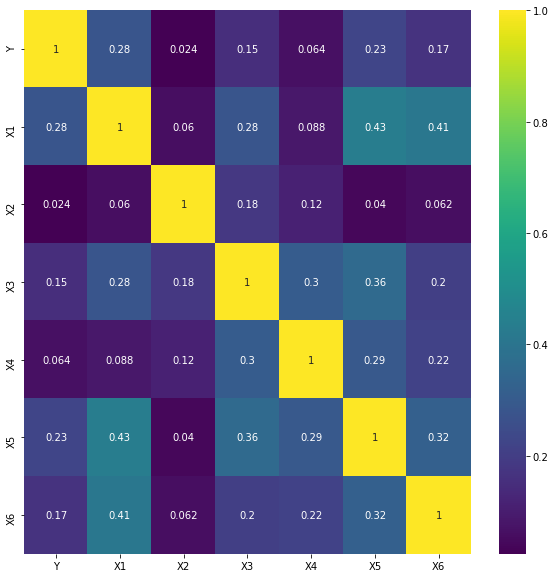

In [143]:
plt.subplots(figsize = (10,10))

sns.heatmap(df.corr().abs().round(3), cmap = 'viridis', annot=True)

As we can see that most features are not correlateed. Also X2 and X4 are least correlated with outcome. 

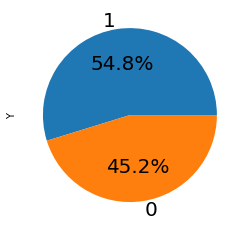

In [144]:
df['Y'].value_counts(normalize = True).plot(kind='pie', autopct='%1.1f%%', fontsize = 20,)

We can see that dataset is slightly unbalanced.However, we can still uses accuracy as evaluation metric. 

## Data Visulzation

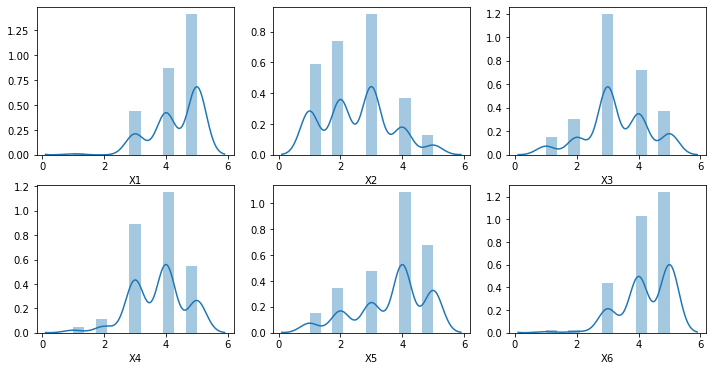

In [145]:
fig,axs = plt.subplots(2,3, figsize = (12,6))

for index in range(6):
#     print(column)
    sns.distplot(df.iloc[:,index+1], ax = axs[index//3, index%3])
    

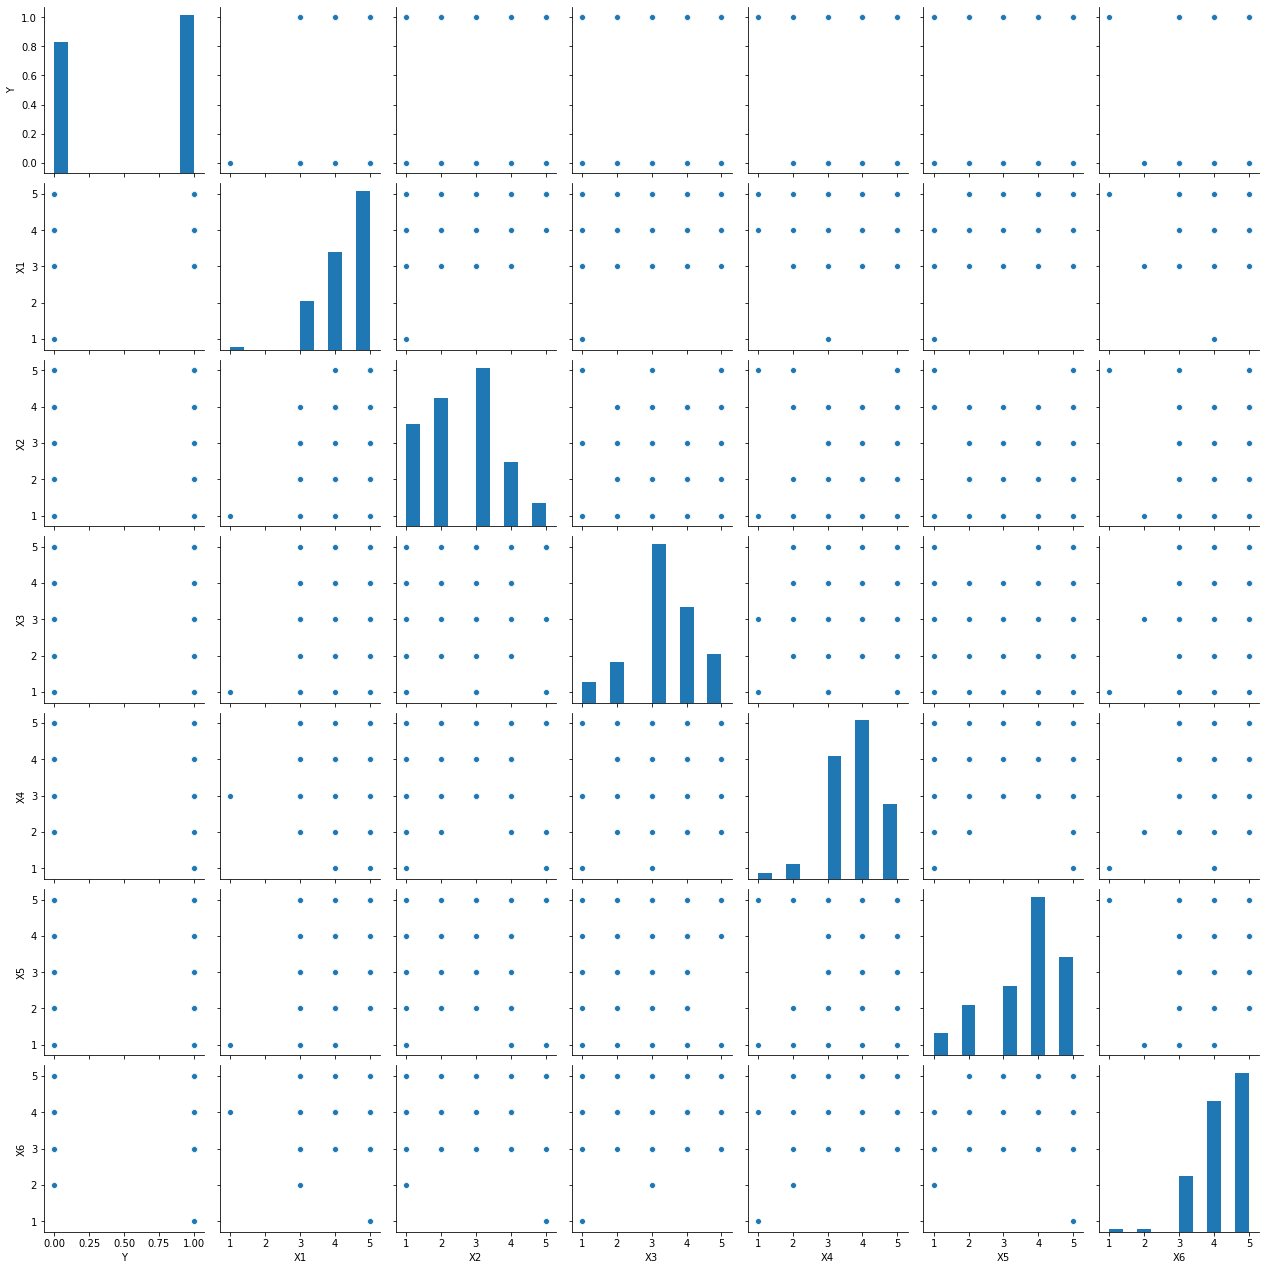

In [146]:
# plt.subplots(figsize = (15,6))
sns.pairplot(df)

## machine Learning

### Train test split

In [147]:
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV

In [148]:
X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.2)

## Models

Lets create a function which runs several models using grid search and report it to experiment logbook.

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score
from time import time
from datetime import datetime
import json

In [150]:
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    
    explog = pd.DataFrame(columns = ['model', 'accuracy_train', 'accuracy_test',
                                     'f1-score_train', 'f1-score_test',
                                     'Training Time', 'Experiments', 'description'])



    models = [['logreg' , LogisticRegression()],
             ['random_forest' , RandomForestClassifier()],
             ['svm' , SVC()],    
             ['XGBoost', XGBClassifier(random_state = 42)],
             ['LightGBM', LGBMClassifier(random_state=42)],
             ]


    params_grid = {'logreg' : {
                'C' : np.logspace(-3,3,7),  
                'fit_intercept' : [True, False],
                },
                   
                   'random_forest' : {
                'n_estimators' : [10,30,50],  
                'max_depth' : [3,6,8],
                },
                   
                   'svm' : {
                'C' : np.logspace(-3,3,7),  
                'kernel' : ['linear', 'poly', 'rbf'],
                'gamma' : ['scale', 'auto']
                },   
                   
                           
                'XGBoost':  {
            'n_estimators' : [10, 30,50], 
            'eta': [0.01, 0.05, 0.1],
            'min_child_weight' : [20, 35],
            'colsample_bytree': [0.8, 0.95],
            'max_depth' : [3,6,8],

                },
                   
                'LightGBM':  {
            'n_estimators' : [10, 50],  
            'boosting_type': ['gbdt'],
            'num_leaves': [10, 20],
            'learning_rate': [0.01, 0.05, 0.1],
            'colsample_bytree': [0.8, 0.95 ],
            'reg_alpha'  : [0.01, 0.02, 0.05],
            'reg_lambda' : [0.01, 0.02, 0.05],
            'min_split_gain' :[0.01, 0.02, 0.05],
                },
            }

 
    
    for (name, regressor) in models:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
            
        
        total_exp = len(ParameterGrid(parameters))*5
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
#         ("scaler", StandardScaler()),
        ("predictor", regressor)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   verbose=verbose)
        grid_search.fit(X_train, y_train,)
                
        # # Best estimator score
        # best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        Train_time = round(time() - start, 4)

        
        y_pred = grid_search.best_estimator_.predict(X_train)
        
        accuracy_train = round(accuracy_score(y_train, y_pred), 3)
        f1_train = round(f1_score(y_train, y_pred), 3)
        
        y_pred_test = grid_search.best_estimator_.predict(X_test)
        
        accuracy_test = round(accuracy_score(y_test, y_pred_test), 3)
        f1_test = round(f1_score(y_test, y_pred_test), 3)

        
        print("Accuracy Train : ", accuracy_train , " "*10, "Accuracy Test : ", accuracy_test)
        print("F1-score Train : ", f1_train , " "*10, "f1-score Test : ", f1_test)

        print('*'*40)
        print('\n')


        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        print("-"*40)
        print("*"*40)
        print("-"*40)
        # Record the results
        explog.loc[len(explog)] = [prefix+name, accuracy_train, accuracy_test,
                                   f1_train, f1_test,
                                   Train_time, total_exp, json.dumps(param_dump)]
        
    sttime = datetime.now().strftime('%Y%m%d_%H:%M:%S - ') 
    display(explog)
    explog.to_csv(sttime + 'experiment_log.csv', index = False)    
    
    


In [151]:
%%time
# This might take a while
if __name__ == "__main__":
    

    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  verbose=1, )
    
#     display(explog)

****** START Best Model: logreg *****
Parameters:
	C: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
	fit_intercept: [True, False]
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy Train :  0.62            Accuracy Test :  0.577
F1-score Train :  0.708            f1-score Test :  0.686
****************************************


Best Parameters:
	predictor__C: 0.1
	predictor__fit_intercept: False
****** FINISH Best Model: logreg  *****

----------------------------------------
****************************************
----------------------------------------
****** START Best Model: random_forest *****
Parameters:
	max_depth: [3, 6, 8]
	n_estimators: [10, 30, 50]
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy Train :  0.87            Accuracy Test :  0.808
F1-score Train :  0.889            f1-score Test :  0.828
****************************************


Best Parameters:
	predictor__max_depth: 8
	predictor__n_estimators: 10
****** FINISH Best Model: random_forest  *****

----------------------------------------
****************************************
----------------------------------------
****** START Best Model: svm *****
Parameters:
	C: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
	gamma: ['scale', 'auto']
	kernel: ['linear', 'poly', 'rbf']
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy Train :  0.64            Accuracy Test :  0.692
F1-score Train :  0.673            f1-score Test :  0.733
****************************************


Best Parameters:
	predictor__C: 0.01
	predictor__gamma: auto
	predictor__kernel: poly
****** FINISH Best Model: svm  *****

----------------------------------------
****************************************
----------------------------------------
****** START Best Model: XGBoost *****
Parameters:
	colsample_bytree: [0.8, 0.95]
	eta: [0.01, 0.05, 0.1]
	max_depth: [3, 6, 8]
	min_child_weight: [20, 35]
	n_estimators: [10, 30, 50]
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy Train :  0.55            Accuracy Test :  0.538
F1-score Train :  0.71            f1-score Test :  0.7
****************************************


Best Parameters:
	predictor__colsample_bytree: 0.8
	predictor__eta: 0.01
	predictor__max_depth: 3
	predictor__min_child_weight: 20
	predictor__n_estimators: 10
****** FINISH Best Model: XGBoost  *****

----------------------------------------
****************************************
----------------------------------------
****** START Best Model: LightGBM *****
Parameters:
	boosting_type: ['gbdt']
	colsample_bytree: [0.8, 0.95]
	learning_rate: [0.01, 0.05, 0.1]
	min_split_gain: [0.01, 0.02, 0.05]
	n_estimators: [10, 50]
	num_leaves: [10, 20]
	reg_alpha: [0.01, 0.02, 0.05]
	reg_lambda: [0.01, 0.02, 0.05]
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Accuracy Train :  0.67            Accuracy Test :  0.692
F1-score Train :  0.692            f1-score Test :  0.714
****************************************


Best Parame

[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed:   25.9s finished


,model,accuracy_train,accuracy_test,f1-score_train,f1-score_test,Training Time,Experiments,description
0,Best Model:logreg,0.62,0.577,0.708,0.686,0.0060,70,"[[""predictor__C"", 0.1], [""predictor__fit_inter..."
1,Best Model:random_forest,0.87,0.808,0.889,0.828,0.0124,45,"[[""predictor__max_depth"", 8], [""predictor__n_e..."
2,Best Model:svm,0.64,0.692,0.673,0.733,0.0030,210,"[[""predictor__C"", 0.01], [""predictor__gamma"", ..."
3,Best Model:XGBoost,0.55,0.538,0.710,0.700,0.0034,540,"[[""predictor__colsample_bytree"", 0.8], [""predi..."
4,Best Model:LightGBM,0.67,0.692,0.692,0.714,0.0084,3240,"[[""predictor__boosting_type"", ""gbdt""], [""predi..."


CPU times: user 2min 55s, sys: 10.1 s, total: 3min 5s
Wall time: 1min 38s


As we see from our experiemnt logbook, we get best result by using Random Forest model. Test accuracy for random forest is 0.808.
We will using Random forest to further develop and use as final model.

## Random Forest - Further Development

In [152]:
explog  = pd.read_csv("20210215_19:28:44 - experiment_log.csv")
explog.iloc[1][-1]

'[["predictor__max_depth", 6], ["predictor__n_estimators", 10]]'

In [168]:

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.2)

parameters = {
                'n_estimators' : np.arange(5,50,5),  
                'max_depth' : np.arange(1,15),
#                 'max_features' : np.arange(1,7)
                }
rf = RandomForestClassifier()
grid = GridSearchCV(rf, parameters , scoring='accuracy', cv = 5, n_jobs=-1)

grid.fit(X_train, y_train)



grid.best_estimator_.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_train)

accuracy_train = round(accuracy_score(y_train, y_pred), 3)
f1_train = round(f1_score(y_train, y_pred), 3)

y_pred_test = grid.best_estimator_.predict(X_test)

accuracy_test = round(accuracy_score(y_test, y_pred_test), 3)
f1_test = round(f1_score(y_test, y_pred_test), 3)


print("Accuracy Train : ", accuracy_train , " "*10, "Accuracy Test : ", accuracy_test)
print("F1-score Train : ", f1_train , " "*10, "f1-score Test : ", f1_test)

print('*'*40)
print('\n')

Accuracy Train :  0.79            Accuracy Test :  0.731
F1-score Train :  0.832            f1-score Test :  0.788
****************************************




In [169]:
grid.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=40)

In [180]:
data_dict = {
    'X1': "On time Delivery",
    "X2" : "Order as expected",
    "X3" : "Item Avaialbility",
    "X4" : "Reasonable Price",
    "X5" : "Delivery Satisfaction / Safe Delivery",
    "X6" : "User Friendly App"
}

In [181]:
list(data_dict.values())

['On time Delivery',
 'Order as expected',
 'Item Avaialbility',
 'Reasonable Price',
 'Delivery Satisfaction / Safe Delivery',
 'User Friendly App']

<BarContainer object of 6 artists>

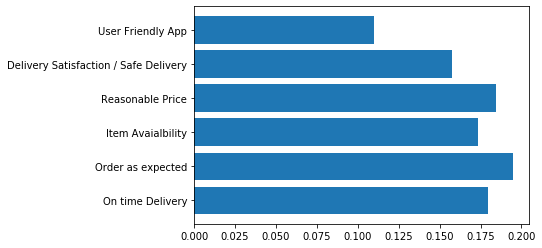

In [182]:
plt.barh(list(data_dict.values()), rf.feature_importances_)
    

In [183]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        #split training data into train and validation subsets
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        
        self.indices_ = tuple(range(dim))
#         print(self.indices_)
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            # look at all combinations of dim-1 features 
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        ## TODO  please complete!
        # using crossfold validation select the single best model from among all selected subsets
        # using cross-validated performance utility
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
#         print(indices)
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

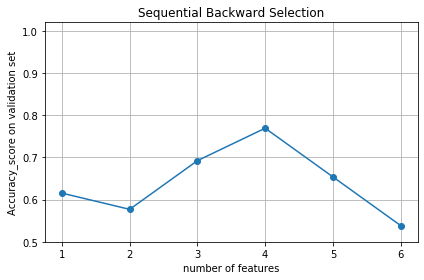

In [186]:
from sklearn.metrics import explained_variance_score
rf = RandomForestClassifier(max_depth=6, n_estimators = 10)
sbs = SBS(rf, k_features=1, scoring=accuracy_score,test_size=0.2)


X = df.drop('Y', axis=1).values
y = df['Y'].values

sbs.fit(X, y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

#plot places the points on the graph using the number of features (no need to sort!)
plt.plot(k_feat, sbs.scores_, marker='o')  
plt.ylim([0.5, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('Accuracy_score on validation set')
plt.xlabel(r'number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [187]:
list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

[(0, 6, 0.538, (0, 1, 2, 3, 4, 5)),
 (1, 5, 0.654, (0, 2, 3, 4, 5)),
 (2, 4, 0.769, (0, 2, 3, 4)),
 (3, 3, 0.692, (0, 3, 4)),
 (4, 2, 0.577, (0, 3)),
 (5, 1, 0.615, (0,))]

By looking t above plot, we can say that maximum accuracy achieved using 4 features which are 



X1 = my order was delivered on time

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier



## Export Best model

In [188]:
best_model = RandomForestClassifier(max_depth=4, n_estimators=40)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=40)

In [190]:
import pickle
filename = 'best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))